In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.user_satisfaction_analysis import *
from scripts.user_experience_analysis import aggregate_customer_data, perform_kmeans_clustering as experience_cluster
from scripts.user_engagement_analysis import aggregate_metrics_per_customer, normalize_and_cluster as engagement_cluster

# Load environment variables from .env file

In [73]:
load_dotenv('../.env/.env')

True

# Retrieve database connection details from environment variables

In [74]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

# Create the connection string

In [75]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)

# Query the data

In [76]:
query = 'SELECT * FROM xdr_data_cleaned'
data_cleaned = pd.read_sql(query, engine)

# Display the data

In [77]:
print(data_cleaned.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [78]:
print(data_cleaned.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

# **Task-4**

# **Task 4.1** - Engagement Score and Experience Score to each user

In [79]:
def aggregate_metrics_per_customer(data_cleaned: pd.DataFrame) -> pd.DataFrame:
    aggregated = data_cleaned.groupby('MSISDN/Number').agg({
        'Bearer Id': 'count',
        'Dur. (ms)': 'sum',
        'Total DL (Bytes)': 'sum',
        'Total UL (Bytes)': 'sum'
    }).reset_index()
    
    aggregated['Total Traffic'] = aggregated['Total DL (Bytes)'] + aggregated['Total UL (Bytes)']
    aggregated.columns = ['MSISDN', 'Sessions', 'Duration', 'DL Traffic', 'UL Traffic', 'Total Traffic']
    
    top_10 = {
        'Sessions': aggregated.nlargest(10, 'Sessions'),
        'Duration': aggregated.nlargest(10, 'Duration'),
        'Total Traffic': aggregated.nlargest(10, 'Total Traffic')
    }
    
    return aggregated, top_10

In [80]:
# aggregrate metrics per customer 
aggregated_data, top_10_customers = aggregate_metrics_per_customer(data_cleaned)

In [81]:
# Engagement analysis
engagement_data, _ = aggregate_metrics_per_customer(data_cleaned)
engagement_normalized, engagement_kmeans = engagement_cluster(engagement_data)

In [82]:
# Experience analysis
experience_data = aggregate_customer_data(data_cleaned)
experience_data, experience_kmeans = experience_cluster(experience_data)

In [83]:
# Check shape of engagmeent_data and experience_data 
print(f"Engagement data shape: {engagement_data.shape}")
print(f"Experience data shape: {experience_data.shape}")

Engagement data shape: (106856, 6)
Experience data shape: (106856, 11)


In [84]:
# check if both data are aligned with MSISDN
engagement_data.head()

,MSISDN,Sessions,Duration,DL Traffic,UL Traffic,Total Traffic
0,3.360100e+10,1,116720.0,8.426375e+08,36053108.0,8.786906e+08
1,3.360100e+10,1,181230.0,1.207552e+08,36104459.0,1.568596e+08
2,3.360100e+10,1,134969.0,5.566597e+08,39306820.0,5.959665e+08
3,3.360101e+10,1,49878.0,4.019932e+08,20327526.0,4.223207e+08
4,3.360101e+10,2,37104.0,1.363130e+09,94280527.0,1.457411e+09


In [85]:
# check if both data are aligned with MSISDN
experience_data.head()

,Avg TCP Retrans DL,Avg TCP Retrans UL,Avg RTT DL,Avg RTT UL,Handset Type,Avg Throughput DL,Avg Throughput UL,Avg TCP Retrans,Avg RTT,Avg Throughput,Cluster
MSISDN/Number,,,,,,,,,,,
3.360100e+10,4.133035e+06,134463.023378,46.000000,0.000000,Huawei P20 Lite Huawei Nova 3E,37.0,39.000000,2.133749e+06,23.000000,38.000000,2
3.360100e+10,4.133035e+06,134463.023378,30.000000,1.000000,Apple iPhone 7 (A1778),48.0,51.000000,2.133749e+06,15.500000,49.500000,2
3.360100e+10,4.133035e+06,134463.023378,54.448072,8.786567,undefined,48.0,49.000000,2.133749e+06,31.617319,48.500000,2
3.360101e+10,1.066000e+03,134463.023378,69.000000,15.000000,Apple iPhone 5S (A1457),204.0,44.000000,6.776451e+04,42.000000,124.000000,2
3.360101e+10,6.741333e+06,77832.511689,57.000000,2.500000,Apple iPhone Se (A1723),20197.5,905.214323,3.409583e+06,29.750000,10551.357162,1


In [86]:
# engagement and experience features 
engagement_features = ['Sessions', 'Duration', 'Total Traffic']
experience_features = ['Avg TCP Retrans', 'Avg RTT', 'Avg Throughput']

In [87]:
# Normalize the data for clustering
scaler = StandardScaler()
engagement_normalized = scaler.fit_transform(engagement_data[engagement_features])
experience_normalized = scaler.fit_transform(experience_data[experience_features])

In [88]:
# Create and fit KMeans models
engagement_kmeans = KMeans(n_clusters=3, random_state=42)
engagement_kmeans.fit(engagement_normalized)

experience_kmeans = KMeans(n_clusters=3, random_state=42)
experience_kmeans.fit(experience_normalized)

KMeans(n_clusters=3, random_state=42)

In [89]:
msisdn_column = data_cleaned['MSISDN/Number']  

engagement_data = engagement_data.reset_index(drop=True)
experience_data = experience_data.reset_index(drop=True)

In [90]:
scores_data = assign_scores(engagement_data[engagement_features], 
                          experience_data[experience_features], 
                          engagement_kmeans, experience_kmeans,
                          msisdn_column)

scores_data

,MSISDN,Engagement Score,Experience Score
0,3.366496e+10,0.785746,0.235946
1,3.368185e+10,0.806738,0.666428
2,3.376063e+10,0.269798,0.530411
3,3.375034e+10,0.323247,1.513960
4,3.369980e+10,2.328949,1.840872
...,...,...,...
106851,3.364566e+10,0.676262,1.135344
106852,3.366865e+10,0.208309,0.380402
106853,3.365069e+10,4.189368,0.533100
106854,3.362189e+10,0.831380,0.532191


# **Task 4.2** - Calculate the Satisfaction Score

In [91]:
scores_data, top_10_satisfied = calculate_satisfaction_scores(scores_data)
print("Top 10 Satisfied Customers:")
top_10_satisfied

Top 10 Satisfied Customers:


,MSISDN,Engagement Score,Experience Score,Satisfaction Score
13180,3.367701e+10,102.277869,0.704306,51.491087
6437,3.362036e+10,59.020947,0.965700,29.993324
92923,3.365081e+10,54.698099,0.974117,27.836108
13526,3.366063e+10,53.376647,0.521635,26.949141
65118,3.369945e+10,49.798549,0.961958,25.380253
50281,3.366319e+10,37.007314,2.848599,19.927956
666,3.366914e+10,37.013448,1.591142,19.302295
57160,3.376359e+10,36.209869,0.530815,18.370342
76363,3.378201e+10,34.359511,1.278768,17.819139
92577,3.364805e+10,33.944117,1.661115,17.802616


# **Task 4.3** - Build a Regression Model

In [92]:
model, mse, r2 = build_regression_model(scores_data)
print(f"Model MSE: {mse}")
print(f"Model R2 Score: {r2}")

Model MSE: 8.928110905734754e-32
Model R2 Score: 1.0


Average Satisfaction Scores per Cluster: [2.192402857387005, 0.9450840145743257]
Average Experience Scores per Cluster: [3.27642849133535, 0.7564752626414588]


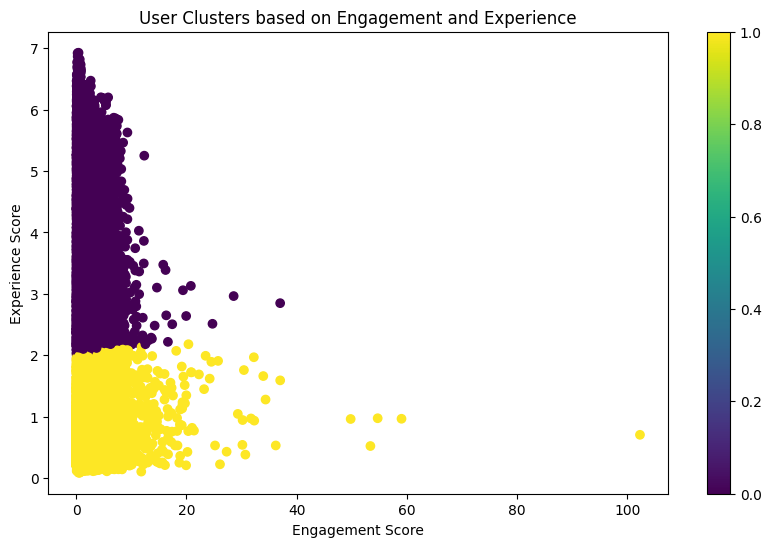

In [93]:
clustered_data, avg_satisfaction, avg_experience = cluster_satisfaction(scores_data)
print(f"Average Satisfaction Scores per Cluster: {avg_satisfaction}")
print(f"Average Experience Scores per Cluster: {avg_experience}")

fig = plot_clusters(clustered_data)
plt.show()